## 3D Reflectivity Plot on $\sigma$ Level from derived dBZ of WRF Simulations. 

**For [High Resolution WRF Simulations of the Current and Future Climate of North America](https://rda.ucar.edu/datasets/ds612.0/).**

**Hungjui Yu 20211026**

In [36]:
import sys
from shutil import copyfile
import time
import datetime as dt
import pytz
from netCDF4 import (Dataset, MFDataset)
import numpy as np
from scipy.interpolate import interpn
import xarray as xr
import pandas as pd
import wrf
from wrf import (getvar, vinterp, interplevel, extract_times, destagger, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

# import metpy
# import metpy.calc as mpcalc
# import metpy.units as units
# print(metpy.__version__)
# import dask


**Set input files paths and names:**

In [37]:
def set_input_names(file_date):

    file_path_1 = '/gpfs/fs1/collections/rda/data/ds612.0'
    file_path_1_dbz = '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0'
    file_path_2 = '/' + wrf_sim_type # '/CTRL3D'
    file_path_3 = '/{}'.format(file_date.strftime('%Y'))

    file_names = dict( dbz = file_path_1_dbz
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_dbz_{}.nc'.format(file_date.strftime('%Y%m%d'))
                       , Z = file_path_1 
                           + file_path_2 
                           + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_Z_{}.nc'.format(file_date.strftime('%Y%m%d'))
                     )
    
    return file_names

In [38]:
## Set wrf simulation type:
wrf_sim_type = 'CTRL3D'
# wrf_sim_type = 'PGW3D'

## Set date time:
case_date_time = dt.datetime(2011,4,27) 
# case_date_time = dt.datetime(2013,9,13) 

file_name_list = set_input_names(case_date_time)
print(file_name_list)

{'dbz': '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0/CTRL3D/2011/wrf3d_d01_CTRL_dbz_20110427.nc', 'Z': '/gpfs/fs1/collections/rda/data/ds612.0/CTRL3D/2011/wrf3d_d01_CTRL_Z_20110427.nc'}


**Load the TERRAIN from INVARIANT data:**

In [39]:
ds_wrf_invariant = xr.open_dataset('/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0/INVARIANT/RALconus4km_wrf_constants.nc')
da_wrf_terrain = ds_wrf_invariant.HGT.isel(Time=0)
# da_wrf_terrain

**Open data on sigma level:**

In [40]:
## Set hour:
## 0:00, 1:03, 2:06, 3:09, 4:12, 5:15, 6:18, 7:21
time_hour_idx = 4

## Set sigma level index:
interp_vertical_lev = 12 # number in levels.

## Get dBZ and the geopotential height:
ds_wrf_dbz = xr.open_dataset(file_name_list['dbz'])
da_wrf_dbz = ds_wrf_dbz['dBZ'].isel(Time=time_hour_idx)

data_wrf_z_unstag = wrf.destagger(getvar(Dataset(file_name_list['Z']), 'Z', timeidx=time_hour_idx, meta=False), 0)


dbz_sigmalev = da_wrf_dbz[interp_vertical_lev,:,:]
geoH_sigmalev = data_wrf_z_unstag[interp_vertical_lev,:,:]

### Test plot:

**Set colorbars:**

In [41]:
## Set NWS reflectivity colorbar:
from metpy.plots import ctables
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', -20, 0.5)

## Set CWB reflectivity colorbar:
clevs = [-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
ccols = ['#ffffff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']
# clevs = [-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
# ccols = ['#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']

**Function: creating new map:**

In [42]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal()
    proj = ccrs.PlateCarree(central_longitude=0)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Set extent:
    # ax.set_global()
    
    ## CONUS:
    # ax.set_extent([-139, -55, 16, 60], crs=proj)    
    ## 9/13 case:
    # ax.set_extent([-115, -95, 32, 43], crs=proj)    
    ## 4/27 case:
    ax.set_extent([-96, -84, 33, 41], crs=proj)
    
    ## Add coast lines:
    ax.coastlines('10m', 'black', linewidth=1)
    
    ## Add features:
    ax.add_feature(cfeat.BORDERS)
    ax.add_feature(cfeat.OCEAN, edgecolor=None, fc='none')
    
    ## Grab state shapefile:
    state_borders = cfeat.NaturalEarthFeature(category='cultural', 
                                              name='admin_1_states_provinces_lines', 
                                              scale='110m', 
                                              facecolor='none',
                                              edgecolor='k'
                                             )
    
    ax.add_feature(state_borders, linewidth=0.8)
    
    ## Add the gridlines:
    latlon_grid_int = 2
    ax_gl = ax.gridlines(crs=ccrs.PlateCarree()
                        ,linewidth=0.5
                        ,color='#454545' 
                        ,alpha=0.9
                        ,linestyle='--'
                        ,draw_labels=True 
                        ,dms=True
                        ,x_inline=False 
                        ,y_inline=False
                        ,xlocs=np.arange(-180, 181, latlon_grid_int)
                        ,ylocs=np.arange(-90, 91, latlon_grid_int)
                        )
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.bottom_labels = True
    ax_gl.left_labels = True
    ax_gl.xlabel_style = {'size': 12, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 12, 'weight': 'bold'}
    
    
    return ax

**Do the plot (dBZ):**

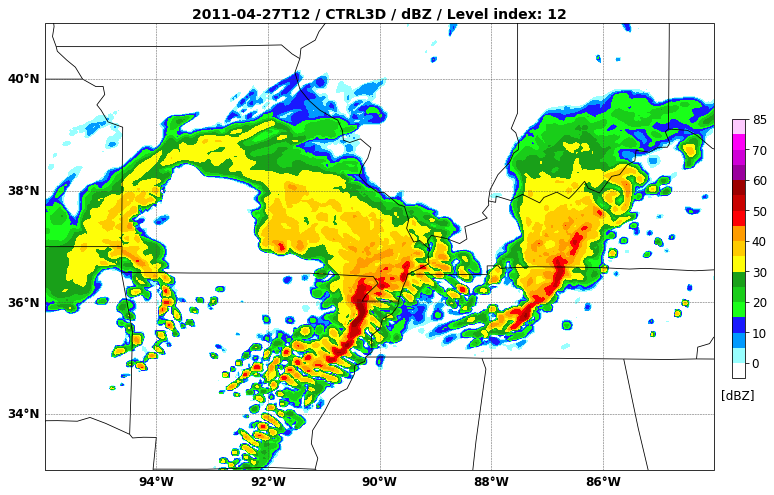

In [43]:
fig = plt.figure(figsize=(12,9))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

plotting_var = dbz_sigmalev.data
plotting_lon = dbz_sigmalev.XLONG
plotting_lat = dbz_sigmalev.XLAT


## CWB colorbar:
cf1 = ax1.contourf(plotting_lon, plotting_lat, plotting_var, levels=clevs, colors=ccols)

## NWS colorbar:
# cf1 = ax1.pcolormesh(plotting_lon, plotting_lat, plotting_var, cmap=ref_cmap, norm=ref_norm, shading='auto')


cf1_title = plt.title( np.datetime_as_string(dbz_sigmalev.Time.data, unit='h') + ' / '
                     + wrf_sim_type + ' / '
                     + dbz_sigmalev.name + ' / '
                     + 'Level index: ' + str(interp_vertical_lev)
                     , fontsize=14 
                     , fontweight='bold'
                     )

cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('[dBZ]', fontsize=12, y=-0.1)


## Save figure:

plt.savefig('./' + np.datetime_as_string(dbz_sigmalev.Time.data, unit='h') + '_dbz_sigma.png', 
            bbox_inches='tight', 
            dpi=300)


**Do the plot (geo-H):**

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


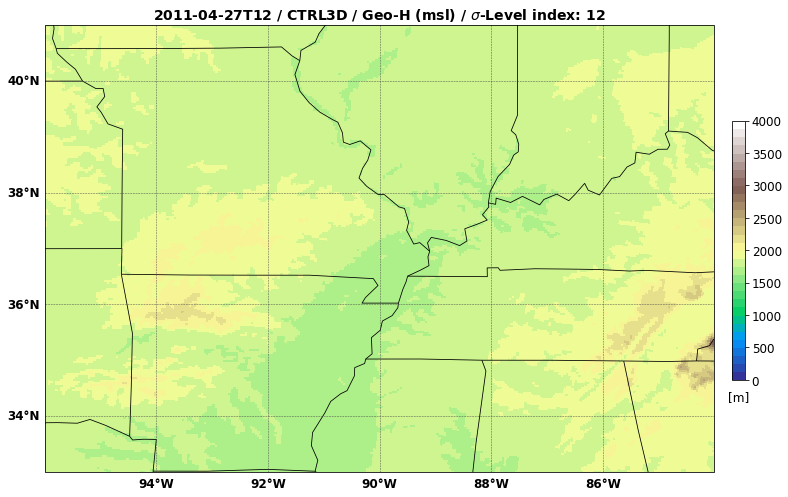

In [44]:
fig = plt.figure(figsize=(12,9))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

plotting_var = geoH_sigmalev
plotting_lon = dbz_sigmalev.XLONG
plotting_lat = dbz_sigmalev.XLAT


cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
                    , cmap=cm.get_cmap('terrain',32) # , cmap=cm.get_cmap('terrain',8)
                    , vmin=0
                    , vmax=4000
                    , shading='auto'
                    )

cf1.cmap.set_under('w')

## Title:
cf1_title = plt.title( np.datetime_as_string(dbz_sigmalev.Time.data, unit='h') + ' / '
                     + wrf_sim_type + ' / '
                     + 'Geo-H (msl) / '
                     + '$\sigma$-Level index: ' + str(interp_vertical_lev)
                     , fontsize=14 
                     , fontweight='bold'
                     )

## Colorbar:
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar( cf1
                   , cax=cbar_ax
                   , fraction=0.04
                   , ticks=np.arange(-500, 5000, 500)
                   # , boundaries=np.arange(-500, 4500, 500)
                   )
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('[m]', fontsize=12, y=-0.1)

## Save figure:

plt.savefig('./' + np.datetime_as_string(dbz_sigmalev.Time.data, unit='h') + '_geoH_sigma.png', 
            bbox_inches='tight', 
            dpi=300)

**Do the plot (AGL):**

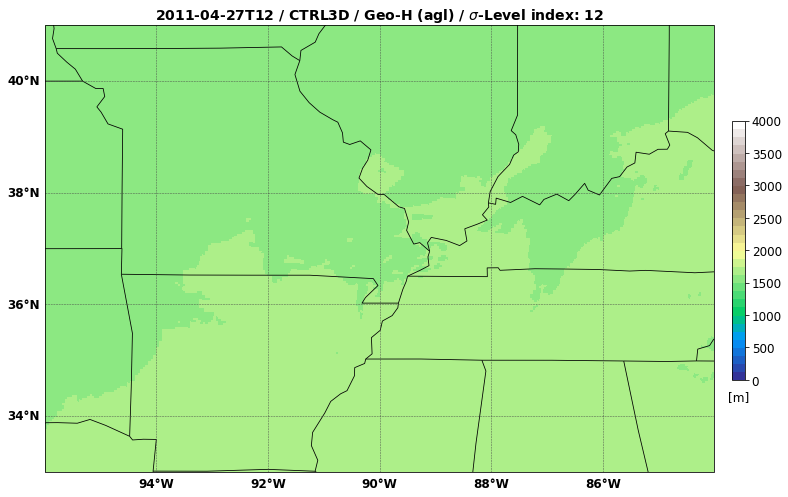

In [45]:
fig = plt.figure(figsize=(12,9))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

plotting_var = geoH_sigmalev - da_wrf_terrain.data
plotting_lon = dbz_sigmalev.XLONG
plotting_lat = dbz_sigmalev.XLAT


cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
                    , cmap=cm.get_cmap('terrain',32)
                    , vmin=0
                    , vmax=4000
                    , shading='auto'
                    )

cf1.cmap.set_under('w')

## Title:
cf1_title = plt.title( np.datetime_as_string(dbz_sigmalev.Time.data, unit='h') + ' / '
                     + wrf_sim_type + ' / '
                     + 'Geo-H (agl) / $\sigma$-Level index: ' + str(interp_vertical_lev)
                     , fontsize=14 
                     , fontweight='bold'
                     )

## Colorbar:
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar( cf1
                   , cax=cbar_ax
                   , fraction=0.04
                   , ticks=np.arange(-500, 5000, 500)
                   # , boundaries=np.arange(-500, 4500, 500)
                   )
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_title('[m]', fontsize=12, y=-0.1)

## Save figure:

plt.savefig('./' + np.datetime_as_string(dbz_sigmalev.Time.data, unit='h') + '_geoH_AGL_sigma.png', 
            bbox_inches='tight', 
            dpi=300)

In [46]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
